In [1]:
# importing moudles
# and using some magic to autoreload them if changed
%load_ext autoreload
%autoreload 2

import sys

sys.path.append('./nonlin')
sys.path.append('./partion')
sys.path.append('./Probs')

from aspen import aspen
from newton import newton

import partion as pt
import wrapper as wp

from one_phase import m1, m2, m3

from one_phase import one_phase
from fix_bd_1D import fxbd_1D
import numpy as np
import matplotlib.pyplot as plt

test = wp.test_decorator(wp.test)
plt.style.use('default')

In [2]:
# model to be studied
def model(u):
    return [u**2+1, 2*max(u, 0), 2]

In [3]:
class Diffusion():
    def __init__(self, Nx, Amp=0, Period=0, Scale=1, model=None):
        self.val = np.zeros((Nx+1, 1))
        for i in range(Nx+1):
            self.val[i] = (
                Amp * np.sin(Period * 2*np.pi * (i+1) / (Nx+1)) + 1) * Scale
        self.model = model

Несмотря на то, что в прошлом тесте не получилось превзойти метод Ньютона, попробуем улучшить результат засчет разбиения доменов

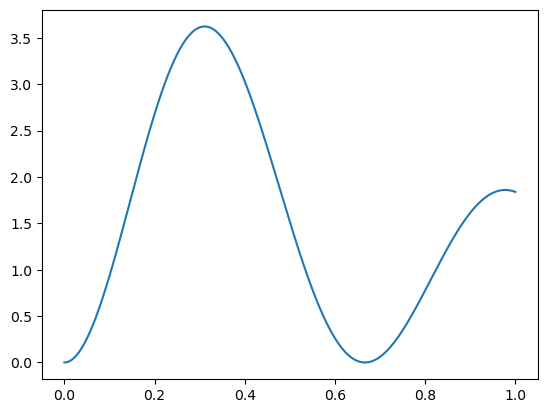

In [4]:
# we will take the same initial condition and grid parameters

Nx = 2000
Nt = 10
param ={'Nx': Nx, 'Nt' : Nt}
x = np.linspace(0, 1, Nx)
D = Diffusion(Nx, 0.9, 5, 0.2e-2, model=model)
x0 = 5*np.exp(-x)*np.sin(3*np.pi/2*x)**2
x0 = x0.reshape(-1, 1)
bd1 = x0[0]
bd2 = x0[-1]

plt.plot(x, x0)
plt.show()

In [5]:
prob = one_phase(D, param)
solver_n = fxbd_1D(param, prob)
solver_n.setBoundary(bd1, bd2)
solver_n.setSources([0.7], [-0.8])
nl_solver = newton(crit_abs=1e-8)
solver_n.setSolver(nl_solver)
solver_n.setInitial(x0)
X, mes, t, delta = test(solver_n, sample_size = 4)

test started


/home/thecreator/miniconda3/envs/py3_study/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


verdict : OK
time : 6.903 +- 0.5848
mean newton iterations:  4.1


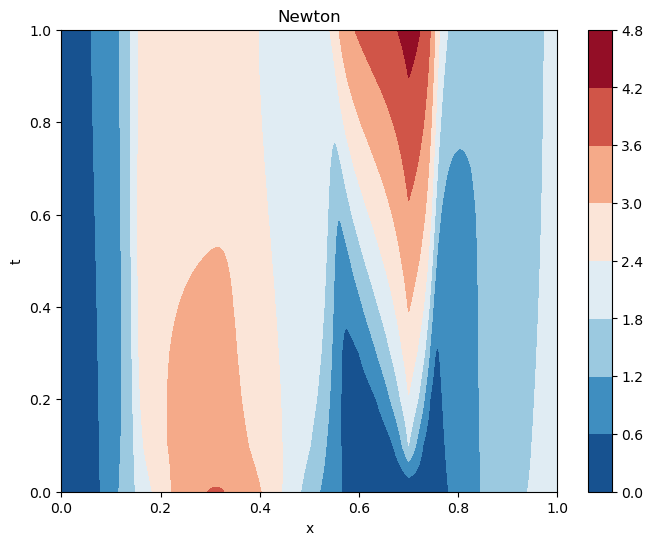

In [6]:
wp.show_res(solver_n)

### Построение доменов через разбиение графа
Две формулировки функции на минимизацию:
$$
    vol(\partial S_i) = \sum_{v \in V_i} \sum_{u \in \Gamma(v), u \notin V_i} {w(v, u)}
$$
Первый способ:$$
\sum \frac{vol(\partial S_i)}{| V_i|} \rightarrow \min
$$Второй способ:$$
\sum \frac{vol(\partial S_i)}{vol(V_i)} \rightarrow \min
$$где $vol(V_i) = \sum_{u, v \in V_i} w(u, v)$

In [7]:
results = {}

In [21]:
Nd = 5
borders = pt.partion_equally(Nx, Nd)
param = {
    'Nx': Nx, 
    'Nt': Nt
}
prob = one_phase(D, param)
solver_eq = fxbd_1D(param, prob)
solver_eq.setBoundary(bd1, bd2)
solver_eq.setSources([0.7], [-0.8])
nl_solver = aspen(Nd, borders, crit_abs = 1e-8, crit_rel = 1e-2)
solver_eq.setSolver(nl_solver)
solver_eq.setInitial(x0)
X, mes, t_as, delta_as = test(solver_eq, sample_size = 4)
results['eq'] = t_as
results['delta, eq'] = delta_as

test started


/home/thecreator/miniconda3/envs/py3_study/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


verdict : OK
time : 17.58 +- 0.9381
mean aspen iterations:  4.7


--time comparision--
newton : 6.53748345375061
aspen : 16.23464584350586


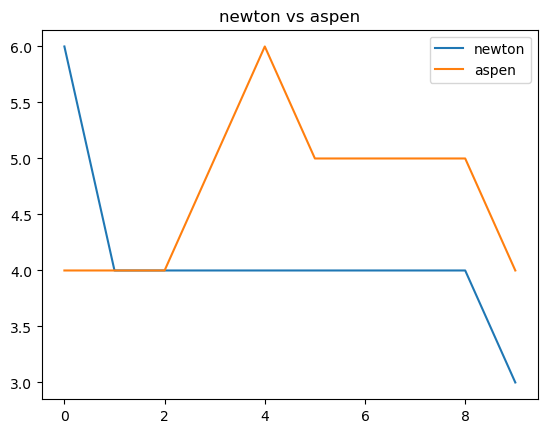

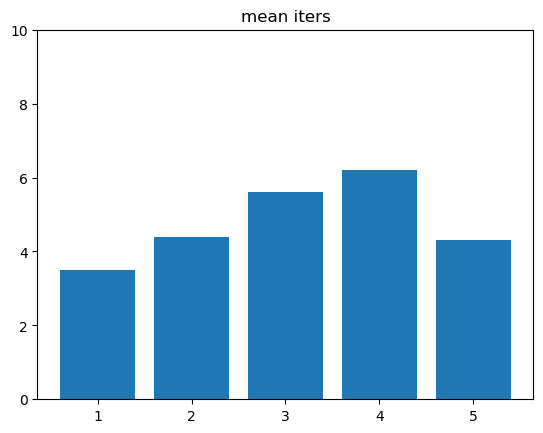

In [22]:
wp.compare([solver_n, solver_eq], ['newton', 'aspen'], save='comp, eq')
wp.bar_loc(solver_eq, Nd, save='bar, eq')

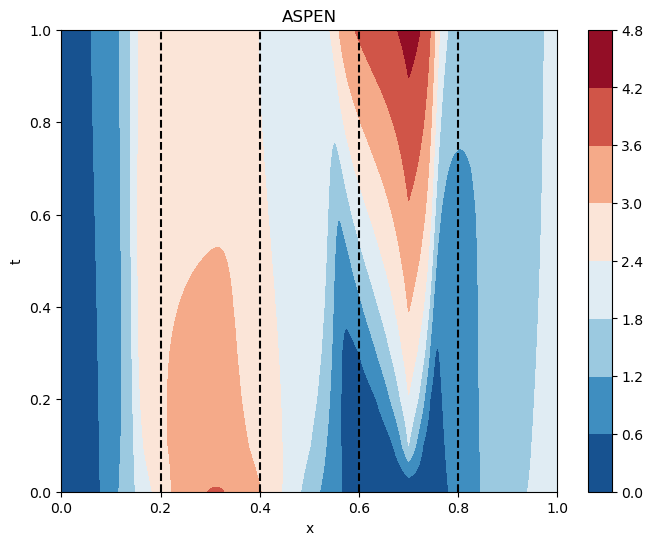

In [124]:
wp.show_res(solver_eq, save='eq_bad')

In [12]:
def border_changer(prob, X, nstep, Nd):
    Jf = prob.precompute_Jf(X[:, nstep], Nx, step = 20)
    #Jf = prob.precompute_Jf(X[:, nstep], Nx)
    func1 = lambda k, m: m1(Jf, k, m)
    A1 = pt.adj_matrix(func1, Nx//20)
    #A1 = pt.adj_matrix(func1, Nx)
    borders = pt.domain_builder2(A1, Nd,
        inv = False, k =Nd)
    borders = borders * 20
    print(borders)
    return borders

Nd = 5
borders = pt.partion_equally(Nx, Nd)
param = {
    'Nx': Nx, 
    'Nt': Nt
}
prob = one_phase(D, param)
solver_m1 = fxbd_1D(param, prob)
solver_m1.setBoundary(bd1, bd2)
solver_m1.setSources([0.7], [-0.8])
nl_solver = aspen(Nd, borders, crit_abs = 1e-8, crit_rel = 1e-2)
solver_m1.setSolver(nl_solver, bd_ch = border_changer)
solver_m1.setInitial(x0)
X, mes, t_as, delta_as = test(solver_m1, sample_size = 4, dyn_bd = True)
results['m1'] = t_as
results['delta, m1'] = delta_as

test started


/home/thecreator/miniconda3/envs/py3_study/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


[   0  300 1100 1500 1880 2000]


/home/thecreator/miniconda3/envs/py3_study/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


[   0  280 1100 1520 1880 2000]


/home/thecreator/miniconda3/envs/py3_study/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


[   0  280  700 1100 1540 2000]


/home/thecreator/miniconda3/envs/py3_study/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


[   0  280  700 1100 1560 2000]


/home/thecreator/miniconda3/envs/py3_study/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


[   0  300 1100 1500 1880 2000]


/home/thecreator/miniconda3/envs/py3_study/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


[   0  280 1100 1520 1880 2000]


/home/thecreator/miniconda3/envs/py3_study/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


[   0  280  700 1100 1540 2000]


/home/thecreator/miniconda3/envs/py3_study/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


[   0  280  700 1100 1560 2000]


/home/thecreator/miniconda3/envs/py3_study/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


[   0  300 1100 1500 1880 2000]


/home/thecreator/miniconda3/envs/py3_study/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


[   0  280 1100 1520 1880 2000]


/home/thecreator/miniconda3/envs/py3_study/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


[   0  280  700 1100 1540 2000]


/home/thecreator/miniconda3/envs/py3_study/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


[   0  280  700 1100 1560 2000]


/home/thecreator/miniconda3/envs/py3_study/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


[   0  300 1100 1500 1880 2000]


/home/thecreator/miniconda3/envs/py3_study/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


[   0  280 1100 1520 1880 2000]


/home/thecreator/miniconda3/envs/py3_study/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


[   0  280  700 1100 1540 2000]


/home/thecreator/miniconda3/envs/py3_study/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


[   0  280  700 1100 1560 2000]


/home/thecreator/miniconda3/envs/py3_study/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


verdict : OK
time : 15.75 +- 0.5521
mean aspen iterations:  4.5


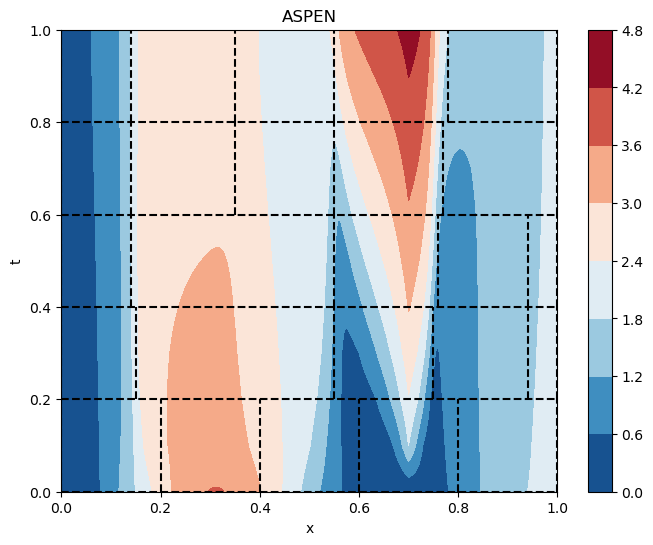

In [14]:
wp.show_res(solver_m1, save='Diff0, m1')

--time comparision--
newton : 6.53748345375061
aspen : 15.83225679397583


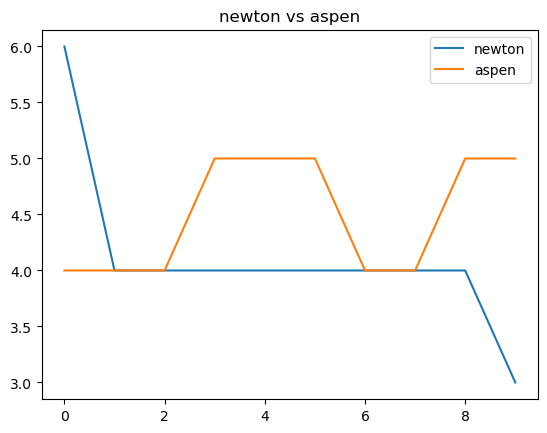

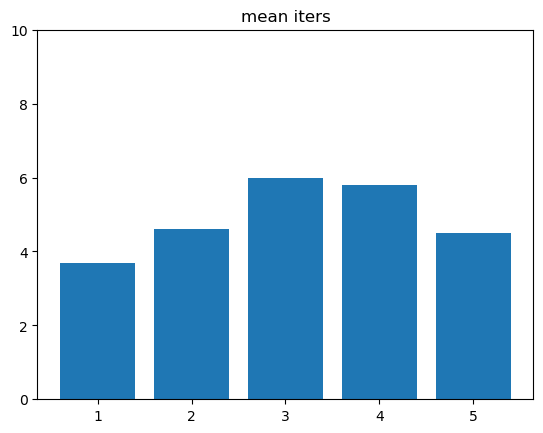

In [15]:
wp.compare([solver_n, solver_m1], ['newton', 'aspen'], save='comp, m1')
wp.bar_loc(solver_m1, Nd, save='bar, m1')

In [17]:
def border_changer(prob, X, nstep, Nd):
    func1 = lambda k, m: m2(X[:, :nstep+1], k, m, x_step = 20)
    #func1 = lambda k, m: m2(X, k, m)
    A2 = pt.adj_matrix(func1, Nx//20)
    #A2 = pt.adj_matrix(func1, Nx)
    borders = pt.domain_builder2(A2, Nd,
        inv = True, k =Nd)
    borders = borders * 20
    print(borders)
    return borders

Nd = 5
borders = pt.partion_equally(Nx, Nd)
param = {
    'Nx': Nx, 
    'Nt': Nt
}
prob = one_phase(D, param)
solver_m2 = fxbd_1D(param, prob)
solver_m2.setBoundary(bd1, bd2)
solver_m2.setSources([0.7], [-0.8])
nl_solver = aspen(Nd, borders, crit_abs = 1e-8, crit_rel = 1e-2)
solver_m2.setSolver(nl_solver, bd_ch = border_changer)
solver_m2.setInitial(x0)
X, mes, t_as, delta_as = test(solver_m2, sample_size = 4, dyn_bd = True)
results['m2'] = t_as
results['delta, m2'] = delta_as

test started


/home/thecreator/miniconda3/envs/py3_study/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


[   0  300  800 1180 1640 2000]


/home/thecreator/miniconda3/envs/py3_study/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


[   0  280  740 1220 1700 2000]


/home/thecreator/miniconda3/envs/py3_study/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


[   0  400  900 1240 1700 2000]


/home/thecreator/miniconda3/envs/py3_study/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


[   0  340  860 1280 1720 2000]


/home/thecreator/miniconda3/envs/py3_study/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


[   0  300  800 1180 1640 2000]


/home/thecreator/miniconda3/envs/py3_study/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


[   0  280  740 1220 1700 2000]


/home/thecreator/miniconda3/envs/py3_study/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


[   0  400  900 1240 1700 2000]


/home/thecreator/miniconda3/envs/py3_study/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


[   0  340  860 1280 1720 2000]


/home/thecreator/miniconda3/envs/py3_study/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


[   0  300  800 1180 1640 2000]


/home/thecreator/miniconda3/envs/py3_study/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


[   0  280  740 1220 1700 2000]


/home/thecreator/miniconda3/envs/py3_study/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


[   0  400  900 1240 1700 2000]


/home/thecreator/miniconda3/envs/py3_study/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


[   0  340  860 1280 1720 2000]


/home/thecreator/miniconda3/envs/py3_study/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


[   0  300  800 1180 1640 2000]


/home/thecreator/miniconda3/envs/py3_study/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


[   0  280  740 1220 1700 2000]


/home/thecreator/miniconda3/envs/py3_study/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


[   0  400  900 1240 1700 2000]


/home/thecreator/miniconda3/envs/py3_study/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


[   0  340  860 1280 1720 2000]


/home/thecreator/miniconda3/envs/py3_study/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


verdict : OK
time : 15.38 +- 0.555
mean aspen iterations:  4.5


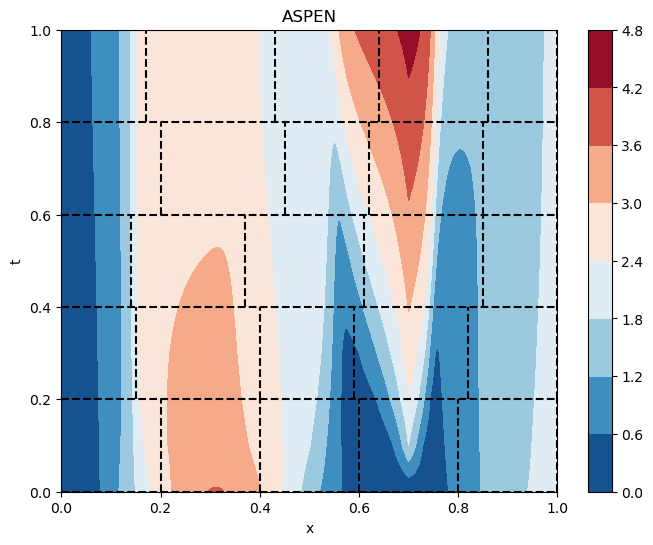

--time comparision--
newton : 6.53748345375061
aspen : 15.594319105148315


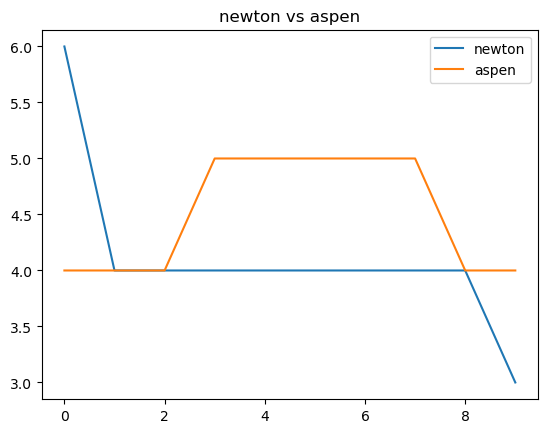

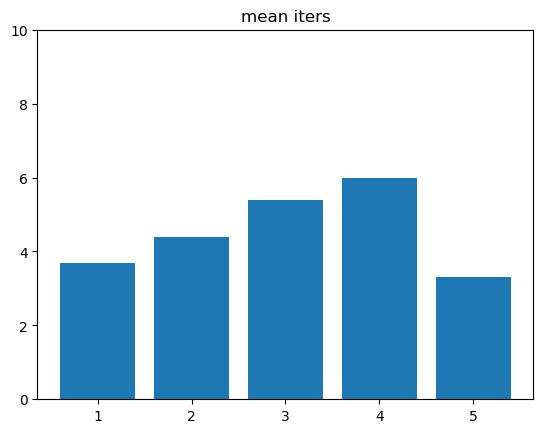

In [18]:
wp.show_res(solver_m2, save='Diff0, m2')
wp.compare([solver_n, solver_m2], ['newton', 'aspen'], save='comp, m2')
wp.bar_loc(solver_m2, Nd, save='bar, m2')

In [19]:
def border_changer(prob, X, nstep, Nd):
    Jf = prob.precompute_Jf(X[:, nstep], Nx, step = 20)
    #Jf = prob.precompute_Jf(X[:, nstep], Nx)
    func1 = lambda k, m: m3(prob, X[:, nstep], Jf, k, m, 10, step = 20)
    #func1 = lambda k, m: m3(prob, X[:, nstep], Jf, k, m, 10)
    A3 = pt.adj_matrix(func1, Nx//20)
    #A3 = pt.adj_matrix(func1, Nx)
    borders = pt.domain_builder2(A3, Nd,
        inv = False, k =Nd)
    borders = borders * 20
    print(borders)
    return borders

Nd = 5
borders = pt.partion_equally(Nx, Nd)
param = {
    'Nx': Nx, 
    'Nt': Nt
}
prob = one_phase(D, param)
solver_m3 = fxbd_1D(param, prob)
solver_m3.setBoundary(bd1, bd2)
solver_m3.setSources([0.7], [-0.8])
nl_solver = aspen(Nd, borders, crit_abs = 1e-8, crit_rel = 1e-2)
solver_m3.setSolver(nl_solver, bd_ch = border_changer)
solver_m3.setInitial(x0)
X, mes, t_as, delta_as = test(solver_m3, sample_size = 4, dyn_bd=True)
results['m3'] = t_as
results['delta, m3'] = delta_as

test started


/home/thecreator/miniconda3/envs/py3_study/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


[   0  400  580  940 1680 2000]


/home/thecreator/miniconda3/envs/py3_study/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


[   0  420  600 1300 1700 2000]


/home/thecreator/miniconda3/envs/py3_study/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


[   0  420  840 1300 1680 2000]


/home/thecreator/miniconda3/envs/py3_study/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


[   0  420  860 1260 1660 2000]


/home/thecreator/miniconda3/envs/py3_study/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


[   0  400  580  940 1680 2000]


/home/thecreator/miniconda3/envs/py3_study/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


[   0  420  600 1300 1700 2000]


/home/thecreator/miniconda3/envs/py3_study/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


[   0  420  840 1300 1680 2000]


/home/thecreator/miniconda3/envs/py3_study/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


[   0  420  860 1260 1660 2000]


/home/thecreator/miniconda3/envs/py3_study/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


[   0  400  580  940 1680 2000]


/home/thecreator/miniconda3/envs/py3_study/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


[   0  420  600 1300 1700 2000]


/home/thecreator/miniconda3/envs/py3_study/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


[   0  420  840 1300 1680 2000]


/home/thecreator/miniconda3/envs/py3_study/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


[   0  420  860 1260 1660 2000]


/home/thecreator/miniconda3/envs/py3_study/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


[   0  400  580  940 1680 2000]


/home/thecreator/miniconda3/envs/py3_study/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


[   0  420  600 1300 1700 2000]


/home/thecreator/miniconda3/envs/py3_study/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


[   0  420  840 1300 1680 2000]


/home/thecreator/miniconda3/envs/py3_study/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


[   0  420  860 1260 1660 2000]


/home/thecreator/miniconda3/envs/py3_study/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


verdict : OK
time : 14.73 +- 0.9656
mean aspen iterations:  4.1


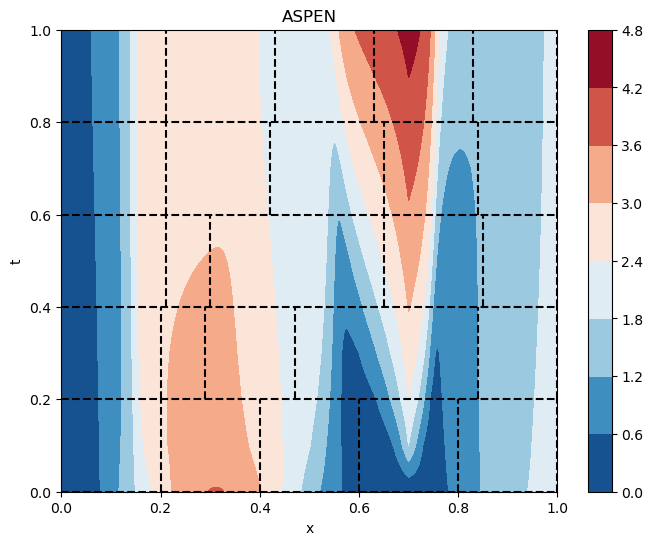

--time comparision--
newton : 6.53748345375061
aspen : 13.97118878364563


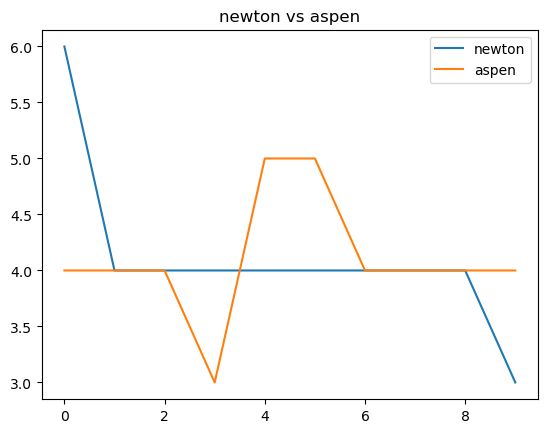

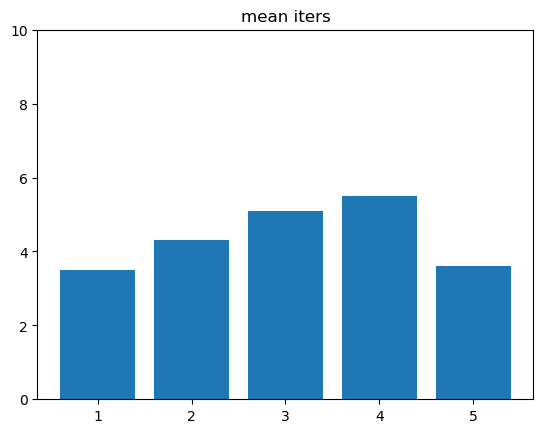

In [20]:
wp.show_res(solver_m3, save='Diff0, m3')
wp.compare([solver_n, solver_m3], ['newton', 'aspen'], save='comp, m3')
wp.bar_loc(solver_m3, Nd, save='bar, m3')

In [24]:
c_r = 3.62172241e-06
c_j = 4.20328463e-06
c_l = 4.19981882e-06

In [59]:
cost_new = solver_n.timelog.kn*Nx*(c_r+c_j+c_l)+c_r*Nx

In [47]:
cost_eq = Nx*( (c_r+c_l)*solver_eq.timelog.aspen_iters+c_r
    + np.mean(solver_eq.timelog.domain_iters, axis = 0)*(c_r+c_l+c_j))

In [48]:
cost_m1 = np.zeros(10)
for i in range(10):
    cost_m1[i] = Nx*( (c_r+c_l)*solver_m1.timelog.aspen_iters[i]+c_r)
    + (c_r+c_l+c_j) \
        * np.sum((solver_m1.timelog.borders[1:, i//2]-solver_m1.timelog.borders[:-1, i//2])*
        solver_m1.timelog.domain_iters[:, i])

In [54]:
cost_m2 = np.zeros(10)
for i in range(10):
    cost_m2[i] = Nx*( (c_r+c_l)*solver_m2.timelog.aspen_iters[i]+c_r)
    + (c_r+c_l+c_j) \
        * np.sum((solver_m2.timelog.borders[1:, i//2]-solver_m2.timelog.borders[:-1, i//2])*
        solver_m2.timelog.domain_iters[:, i])

In [64]:
cost_m3 = np.zeros(10)
for i in range(10):
    cost_m3[i] = Nx*( (c_r+c_l)*solver_m3.timelog.aspen_iters[i]+c_r)
    + (c_r+c_l+c_j) \
        * np.sum((solver_m3.timelog.borders[1:, i//2]-solver_m3.timelog.borders[:-1, i//2])*
        solver_m3.timelog.domain_iters[:, i])

[400. 400. 400. 400. 400.]
[400. 400. 400. 400. 400.]
[400. 180. 360. 740. 320.]
[400. 180. 360. 740. 320.]
[420. 180. 700. 400. 300.]
[420. 180. 700. 400. 300.]
[420. 420. 460. 380. 320.]
[420. 420. 460. 380. 320.]
[420. 440. 400. 400. 340.]
[420. 440. 400. 400. 340.]


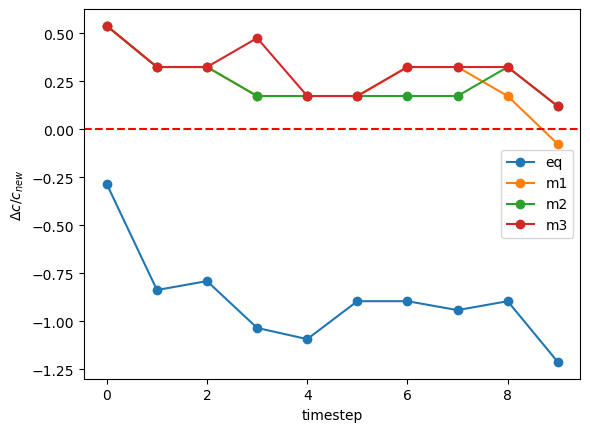

In [60]:
plt.plot(np.arange(Nt), (cost_new-cost_eq)/cost_new, marker='o', label='eq')
plt.plot(np.arange(Nt), (cost_new-cost_m1)/cost_new, marker='o', label='m1')
plt.plot(np.arange(Nt), (cost_new-cost_m2)/cost_new, marker='o', label='m2')
plt.plot(np.arange(Nt), (cost_new-cost_m3)/cost_new, marker='o', label='m3')
plt.axhline(0, linestyle='--', color='r')

plt.xlabel('timestep')
plt.ylabel('$\Delta c/c_{new}$')
plt.legend()
plt.savefig('./data/metrics_comp_over_time_eq', dpi = 300)
plt.show()